<a href="https://colab.research.google.com/github/Lasulux/Midterm_Project/blob/master/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary: 

My task was to create an object detection network able to recognize malaria infected cells in a blood sample. I managed to extract and augment the given data to individual cell images and background images and used those for training an image classification network, constructed from convolutional and fully connected layers. I planned to implement a sliding window and run through the whole image and classify each cutout, then filter through these bounding boxes. Sadly I could not reach the desired outcome and the network misses a lot of cells.




Sources:

Preview code from:
https://www.kaggle.com/kmader/malaria-preview

Visualization code from:
https://github.com/maki-ai/SSD-Tensorflow/blob/pazmany_dl/notebooks/visualization.py

sliding window tutorial at: https://www.pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/ and https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

I used many more online sources for research and debugging while writing this code. I did not copy a pre-made code and augmented all sources to be able to implement them as best I could.



Attaching my drive to load data:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
import math
import tensorflow as tf 
import time
import imutils
import cv2
import os
import random
from google.colab.patches import cv2_imshow
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pathlib import Path
from skimage.io import imread
from skimage.color import label2rgb
from IPython.display import clear_output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow import keras
import sklearn
from skimage.transform import resize
from random import randrange
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
malaria_dir = Path('../input/malaria/malaria/')

In [0]:
model = tf.keras.models.load_model('/content/drive/My Drive/CNN5.model')

This visualization code draws the bboxes and attaches the category number and score:

In [0]:
def plt_bboxes(img, classes, scores, bboxes, figsize=(10,10), linewidth=1.5):
    """Visualize bounding boxes. Largely inspired by SSD-MXNET!"""
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    for i in range(classes.shape[0]):
        cls_id = int(classes[i])
        if cls_id >= 0:
            score = scores[i]
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            ymin = int(bboxes[i, 0] * height)
            xmin = int(bboxes[i, 1] * width)
            ymax = int(bboxes[i, 2] * height)
            xmax = int(bboxes[i, 3] * width)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=linewidth)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            plt.gca().text(xmin, ymin - 2,
                           '{:s} | {:.3f}'.format(class_name, score),
                           bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                           fontsize=5, color='white')
    plt.show()

This is just a small block to switch the category names to numbers because if you display the whole names the image becomes too crowded to read:

In [0]:
def cat_to_num(category):
  categories = ['red blood cell','leukocyte','trophozoite','ring','schizont','gametocyte','difficult','background']
  num = categories.index(category)
  return num

Read data json, check what I have in the dataframe:

In [5]:
train_df = pd.read_json('/content/drive/My Drive/malaria-bounding-boxes/malaria/malaria/training.json')
train_df['path'] = train_df['image'].map(lambda x:  x['pathname'][1:])
print(train_df.shape[0], 'images')
train_df.sample(5)

1208 images


,image,objects,path
178,{'checksum': '6a759217dc3af180400ff039fedb870f...,"[{'bounding_box': {'minimum': {'r': 754, 'c': ...",images/834a30bb-26bf-4e60-9ea1-3250b926892e.png
57,{'checksum': '14cb04f97d3cb4b3348e637408b64c55...,"[{'bounding_box': {'minimum': {'r': 712, 'c': ...",images/73dd09d3-2bff-4b5e-b996-9da0b8b54a8f.png
529,{'checksum': 'f039c30cafd90448fb0045fccf1c6e66...,"[{'bounding_box': {'minimum': {'r': 104, 'c': ...",images/1a332b2c-9d49-4ff2-810c-5633d2314527.png
810,{'checksum': '8d89dc11e652617da6883b7a949ec5c0...,"[{'bounding_box': {'minimum': {'r': 633, 'c': ...",images/a6fe423a-5204-4378-bcfa-d6d298a3e9aa.png
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ...",images/10be6380-cbbb-4886-8b9e-ff56b1710576.png


In [6]:
test_df = pd.read_json('/content/drive/My Drive/malaria-bounding-boxes/malaria/malaria/test.json')
test_df['path'] = test_df['image'].map(lambda x:  x['pathname'][1:])
print(test_df.shape[0], 'images')
test_df.sample(5)

120 images


,image,objects,path
90,{'checksum': 'e7ab47b3f69f3069aed7a7c27d8d9cd9...,"[{'bounding_box': {'minimum': {'r': 423, 'c': ...",images/6d9a2241-2cce-42b3-a11d-a3a6b432dd89.jpg
102,{'checksum': 'cfcd2704ec99875cb87989e5d85be9cf...,"[{'bounding_box': {'minimum': {'r': 368, 'c': ...",images/bd4da4f8-8996-47e0-a4e5-a3da5717441e.jpg
12,{'checksum': '309e3244e5ec658265a78b2d883678fa...,"[{'bounding_box': {'minimum': {'r': 1069, 'c':...",images/c11081a1-4fd9-4003-8bd9-0727eae62d0a.jpg
114,{'checksum': '4818bd2700664f3aebfdd93e13f25d7d...,"[{'bounding_box': {'minimum': {'r': 575, 'c': ...",images/3147f1e4-6fc4-4eff-a9dd-ddeee5e2de13.jpg
111,{'checksum': '8f0de170b00bbb72b1b1e5822558baab...,"[{'bounding_box': {'minimum': {'r': 940, 'c': ...",images/c328260d-bafa-4aaa-9e7a-79bc165d7fdb.jpg


Choose an image, find all objects in it and put them in arrays then draw the bboxes from the them. Also draw the image:

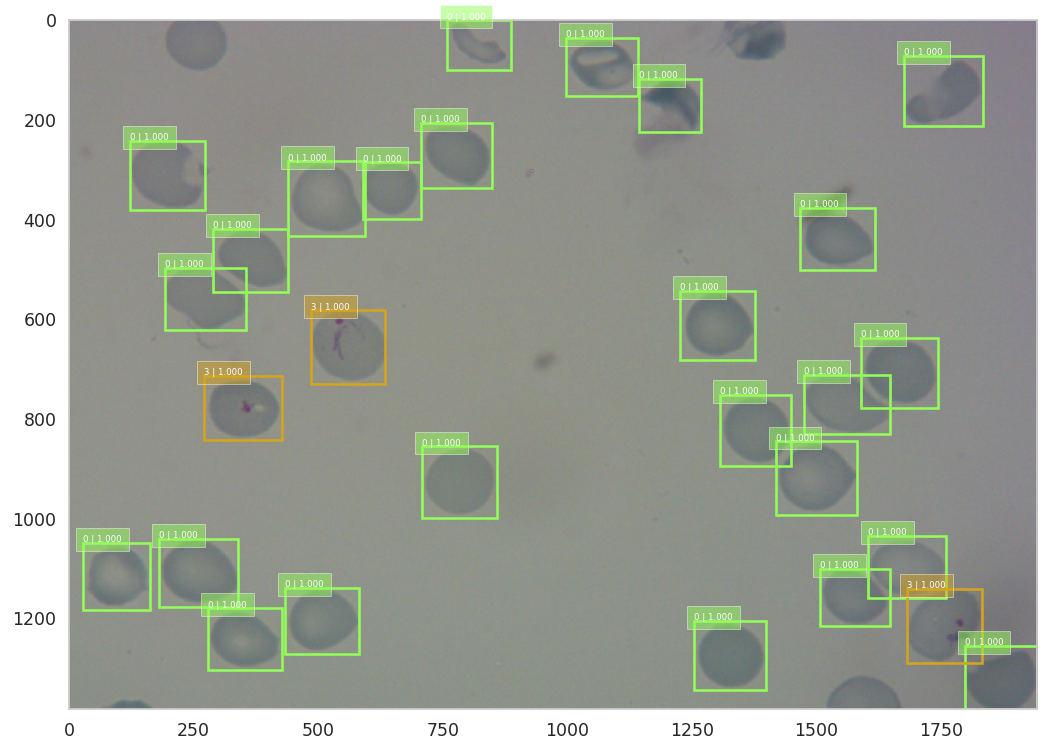

In [23]:
test_row = test_df.iloc[8]
def show_image_boxes(in_row, ax=None):
    c_img = imread('drive/My Drive/malaria-bounding-boxes/malaria/malaria/' + in_row['path'])
    lab_img = np.zeros((c_img.shape[0], c_img.shape[1]), dtype='int')
    classes=[]
    scores=[]
    bboxes=[]
    for c_obj in in_row['objects']:
        bbx1 = c_obj['bounding_box']['minimum']['r']/lab_img.shape[0]
        bby1 = c_obj['bounding_box']['minimum']['c']/lab_img.shape[1]
        bbx2 = c_obj['bounding_box']['maximum']['r']/lab_img.shape[0]
        bby2 = c_obj['bounding_box']['maximum']['c']/lab_img.shape[1]
        classes.append(cat_to_num(c_obj['category']))
        scores.append(1.00)
        bboxes.append([bbx1,bby1,bbx2,bby2])
    bboxes=np.array(bboxes)
    classes=np.array(classes)
    scores=np.array(scores)
    bboxes=np.reshape(bboxes,(-1,4))
    plt_bboxes(c_img, classes, scores, bboxes)
show_image_boxes(test_row)

Checking a few dozen pictures, the cells are about the same size on every picture. I will try applying a sliding window with about this size to find unhealthy cells. Since we want to know whether the blood is healthy or infected, not knowing the exact number of infected cells on picture SHOULD be fine, but I'll try to overcome that when (IF) I get there.

Sliding window:

In [0]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image ٩(^ᴗ^)۶
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

Image getter to use later:

In [0]:
def get_image(number,istest=False):
  if (istest==True):
    c_img = imread('drive/My Drive/malaria-bounding-boxes/malaria/malaria/' + test_df.iloc[number]['path'])
    return c_img
  else:
    c_img = imread('drive/My Drive/malaria-bounding-boxes/malaria/malaria/' + train_df.iloc[number]['path'])
    return c_img


Image resizing snippet:

In [0]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
  yield image #original image

  w = int(image.shape[1] / scale)
  image = imutils.resize(image, width=w)

  yield image


IOU calculation for the overlapping bboxes.

In [0]:
def calc_iou(bbox1,bbox2):

    def intersection (bbox1,bbox2):
      return max(bbox1[2] - bbox2[0],0)*max(bbox1[3] - bbox2[1],0)

    def union (bbox1,bbox2):
      return (bbox1[2]-bbox1[0]) * (bbox1[3]-bbox1[1]) + (bbox2[2]-bbox2[0]) * (bbox2[3]-bbox2[1]) - intersection (bbox1,bbox2)

    IoU = intersection(bbox1,bbox2) / union(bbox1,bbox2)#max(union(bbox1,bbox2),0.0000000001) #no zero divison
    return IoU

Function for discarding overlapping boxes.

In [0]:
def bboxes_nms(classes,scores,bboxes,nms_threshold=0.45):
    newclasses=[]
    newscores=[]
    newbboxes=[]
    available=np.full((classes.shape[0]), True, dtype=bool)
    for i, val in enumerate(classes):
      for j, val in enumerate(classes):
        if(classes[i]==classes[j] and j!=i):
          if (calc_iou(bboxes[i],bboxes[j])>=nms_threshold):
              if (scores[i]>=scores[j]):
                available[j]=False
                if available[i]:
                  available[i]=False
                  newbboxes.append(bboxes[i][0])
                  newbboxes.append(bboxes[i][1])
                  newbboxes.append(bboxes[i][2])
                  newbboxes.append(bboxes[i][3])
                  newclasses.append(classes[i])
                  newscores.append(scores[i])
              else:
                available[i]=False
                if available[j]:
                  available[j]=False
                  newclasses.append(classes[j])
                  newscores.append(scores[j])
                  newbboxes.append(bboxes[j][0])
                  newbboxes.append(bboxes[j][1])
                  newbboxes.append(bboxes[j][2])
                  newbboxes.append(bboxes[j][3])
    newbboxes=np.array(newbboxes)
    newclasses=np.array(newclasses)
    newscores=np.array(newscores)
    newbboxes=np.reshape(newbboxes,(-1,4))
    return newclasses,newscores,newbboxes

Take an image, slide the window over it. If there is no gt bbox overlapping and the variance is not too high, save it. I'll use this to generate training background data images.

In [0]:
Winsize= 128
stepsize= math.ceil(Winsize * 0.4)
(winW, winH) = (Winsize, Winsize)
height = image.shape[0]
width = image.shape[1]
iou_threshold=0.1
dataframe=train_df
winbboxes=[]
winclasses=[]
winscores=[]
winimgs=[]
winclass= 7
jj=0
end=dataframe.shape[0]
while(len(winclasses)<1000):
  if (jj%10==0):
    print(len(winclasses))
  c_img=get_image(jj)                                                            #get an original image
  lab_img = np.zeros((c_img.shape[0], c_img.shape[1]), dtype='int')
  classes=[]
  bboxes=[]                                                                     #no need for scores, this is training data
  for c_obj in train_df.iloc[jj]['objects']:                                    #get original bboxes from image with classes
      bbx1 = c_obj['bounding_box']['minimum']['r']/lab_img.shape[0]
      bby1 = c_obj['bounding_box']['minimum']['c']/lab_img.shape[1]
      bbx2 = c_obj['bounding_box']['maximum']['r']/lab_img.shape[0]
      bby2 = c_obj['bounding_box']['maximum']['c']/lab_img.shape[1]
      bboxes.append([bbx1,bby1,bbx2,bby2])
      classes.append(cat_to_num(c_obj['category']))
  bboxes=np.array(bboxes)
  classes=np.array(classes)

  for (x, y, window) in sliding_window(c_img, stepsize, windowSize=(winW, winH)):#slidey window
    if window.shape[0] != winH or window.shape[1] != winW:                      #if the window shape isn't proper, stop
      continue
    
    wincoord=np.array([y/height, x/width, (y+winH)/height, (x+winW)/width])     #get window coords
    window_valid=True

    for j,val in enumerate(bboxes):                                             #find matching gt bbox to our window thats above threshold
      if (calc_iou(wincoord,bboxes[j])>=iou_threshold or x>1450 or y>1000 ):
        window_valid=False                                                      #if there is one, the window is not good as background
        break
            
    if window_valid:                                                            #if no gt bbox overlaps, our window is valid for background image
      img2 = c_img[math.ceil(c_img.shape[0]*wincoord[1]):math.ceil(c_img.shape[0]*wincoord[3]),math.ceil( c_img.shape[1]*wincoord[0]):math.ceil(c_img.shape[1]*wincoord[2]),:]
      img2 = resize(img2, (128, 128))
      if np.var(img2[...,:])<0.0015:                                            #Check variance. There are cells that are not bboxed
        winbboxes.append(wincoord)                                              #so this sorts them out mostly
        winclasses.append(winclass)                                             #add the cutout background image to window data
        winscores.append(1)
        winimgs.append(img2)
  jj=jj+1
      
winbboxes=np.array(winbboxes)
winscores=np.array(winscores)
winclasses=np.array(winclasses)
winimgs=np.array(winimgs)

Cut out the individual cells and label them. Can rotate the images 4*90°, can augment images by moving the cutout around randomly. Goes until it generated an equal amount of all classes.




In [0]:
def gen_train_cells(dataframe=train_df,tfrom=0,tto=1,tfilter=True,vvfilter=0.05,t2filter=0.5,rotate=False,augment=True,maxclasscount=2000):
  from random import randrange
  lower_classes=[]
  lower_bboxes=[]
  lower_bboximages=[]
  lower_classes.clear()
  lower_bboxes.clear()
  lower_bboximages.clear()
  j=0
  end=dataframe.shape[0]
  classcounter=np.array([0,0,0,0,0,0,0])
  vvcount=0
  t2count=0

  while(np.any(classcounter<maxclasscount)):
    in_row = dataframe.iloc[j]
    j=j+1
    if j>=end:
      j=0
    if (j%10==0):
      print(classcounter)

    c_img = imread('drive/My Drive/malaria-bounding-boxes/malaria/malaria/' + in_row['path'])
    lab_img = np.zeros((c_img.shape[0], c_img.shape[1]), dtype='int')

    for c_obj in in_row['objects']:
        bbx1 = c_obj['bounding_box']['minimum']['r']/lab_img.shape[0]
        bby1 = c_obj['bounding_box']['minimum']['c']/lab_img.shape[1]
        bbx2 = c_obj['bounding_box']['maximum']['r']/lab_img.shape[0]
        bby2 = c_obj['bounding_box']['maximum']['c']/lab_img.shape[1]

        if (cat_to_num(c_obj['category']))==0 :                                 #Additional filters for Red blood cells and trophozoite
            vvcount=vvcount+1                                                   #They are the most common and fill up fast
            if(vvcount%(400)!=0):                                               #Without filters we would end up with a lot of cells
              continue                                                          #From the same image
        if (cat_to_num(c_obj['category']))==2 :
            t2count=t2count+1
            if(t2count%(10)!=0):
              continue
        if (classcounter[cat_to_num(c_obj['category'])])<maxclasscount :        #Check number of saved cells in this category
            lower_bboxes.append([bbx1,bby1,bbx2,bby2])                          #if under the limit, save this cutout
            lower_classes.append(cat_to_num(c_obj['category']))
            img2 = c_img[math.ceil(c_img.shape[0]*bbx1)   :   math.ceil(c_img.shape[0]*bbx2),
                         math.ceil( c_img.shape[1]*bby1)  :   math.ceil(c_img.shape[1]*bby2),:]
            img2 = resize(img2, (128, 128))
            if rotate==True:
              lower_bboxes.append([bbx1,bby1,bbx2,bby2])
              lower_bboxes.append([bbx1,bby1,bbx2,bby2])
              lower_bboxes.append([bbx1,bby1,bbx2,bby2])
              lower_classes.append(cat_to_num(c_obj['category']))
              lower_classes.append(cat_to_num(c_obj['category']))
              lower_classes.append(cat_to_num(c_obj['category']))
              lower_bboximages.append(img2)
              lower_bboximages.append(img2.swapaxes(-3,-2)[::-1,::,:])          #I rotate by mirroring the image on X,Y axis
              lower_bboximages.append(img2.swapaxes(-3,-2)[::,::,:])
              lower_bboximages.append(img2.swapaxes(-3,-2)[::,::-1,:])
              classcounter[cat_to_num(c_obj['category'])]=classcounter[cat_to_num(c_obj['category'])]+4
            else:
              lower_bboximages.append(img2)
              classcounter[cat_to_num(c_obj['category'])]=classcounter[cat_to_num(c_obj['category'])]+1
            if augment==True:
              for x in range(5):                                                #if the image is not close to the edge
                if bbx2<0.95 and bbx1>0.05 and bby2<0.95 and bby1>0.05:         #we can nudge the cutout window in a random direction
                  lower_bboxes.append([bbx1,bby1,bbx2,bby2])
                  lower_classes.append(cat_to_num(c_obj['category']))
                  xoffset=(randrange(11)-5)/100
                  yoffset=(randrange(11)-5)/100
                  randimg=c_img[math.ceil(c_img.shape[0]*(bbx1+xoffset)):math.ceil(c_img.shape[0]*(bbx2+xoffset)),math.ceil( c_img.shape[1]*(bby1+yoffset)):math.ceil(c_img.shape[1]*(bby2+yoffset)),:]
                  randimg = resize(randimg, (128, 128))
                  lower_bboximages.append(randimg)
                  classcounter[cat_to_num(c_obj['category'])]=classcounter[cat_to_num(c_obj['category'])]+1

  return lower_bboximages,lower_classes,lower_bboxes

Call the cell generator. We can decide how much of each cell we want and if we want to rotate, augment.

In [0]:
#gen_train_cells(dataframe=train_df,tfrom=0,tto=1,tfilter=False,vvfilter=0.01,t2filter=0.2,rotate=False) ___:test_df
lower_rot_bboximages,lower_rot_classes,lower_rot_bboxes= gen_train_cells(rotate=True,augment=True,maxclasscount=3000)

Similiar method for cutting out test cells seperately

In [12]:
from skimage.transform import resize
from google.colab import files
ttext_classes=[]
tclasses=[]
tbboxes=[]
tbboximages=[]
ttext_classes.clear()
tclasses.clear()
tbboxes.clear()
tbboximages.clear()
j=0
end=test_df.shape[0]
for j in range(0,end):
  tc_img=get_image(j,istest=True)
  tlab_img = np.zeros((tc_img.shape[0], tc_img.shape[1]), dtype='int')
  if (j%10==0):
    print(j)
  for tc_obj in test_df.iloc[j]['objects']:#get original bboxes from image with classes
      bbx1 = tc_obj['bounding_box']['minimum']['r']/tlab_img.shape[0]
      bby1 = tc_obj['bounding_box']['minimum']['c']/tlab_img.shape[1]
      bbx2 = tc_obj['bounding_box']['maximum']['r']/tlab_img.shape[0]
      bby2 = tc_obj['bounding_box']['maximum']['c']/tlab_img.shape[1]
      tbboxes.append([bbx1,bby1,bbx2,bby2])
      tclasses.append(cat_to_num(tc_obj['category']))
      ttext_classes.append(tc_obj['category'])
      img2 = tc_img[math.ceil(tc_img.shape[0]*bbx1):math.ceil(tc_img.shape[0]*bbx2),math.ceil( tc_img.shape[1]*bby1):math.ceil(tc_img.shape[1]*bby2),:]
      img2 = resize(img2, (128, 128))
      tbboximages.append(img2)
      

0
10
20
30
40
50
60
70
80
90
100
110


Transforming every list to arrays. These are done seperately becuase I kept crashing when doing them at once or at the end of generator blocks

In [0]:
nptbboximages=np.array(tbboximages)
nptbboxes=np.array(tbboxes)
nptclasses=np.array(tclasses)
nptbboxes=np.reshape(tbboxes,(-1,4))

In [0]:
lower_bboxes=np.array(lower_rot_bboxes)

In [0]:
lower_classes=np.array(lower_rot_classes)

In [0]:
lower_bboximages=np.array(lower_rot_bboximages)

In [0]:
train_bboximages=np.concatenate((lower_bboximages,winimgs),axis=0)
train_classes=np.concatenate((lower_classes,winclasses),axis=0)

We can check how many cells with what classes we ended up with

In [0]:
unique, counts = np.unique(train_classes, return_counts=True)
print(dict(zip(unique, counts)))

View some individual cells and their labels:



*   nptbboximages show test images
*   lower_bboximages shows training images
*   winimgs shows the background images made with sliding window
*   train_bboximages shows training and background images





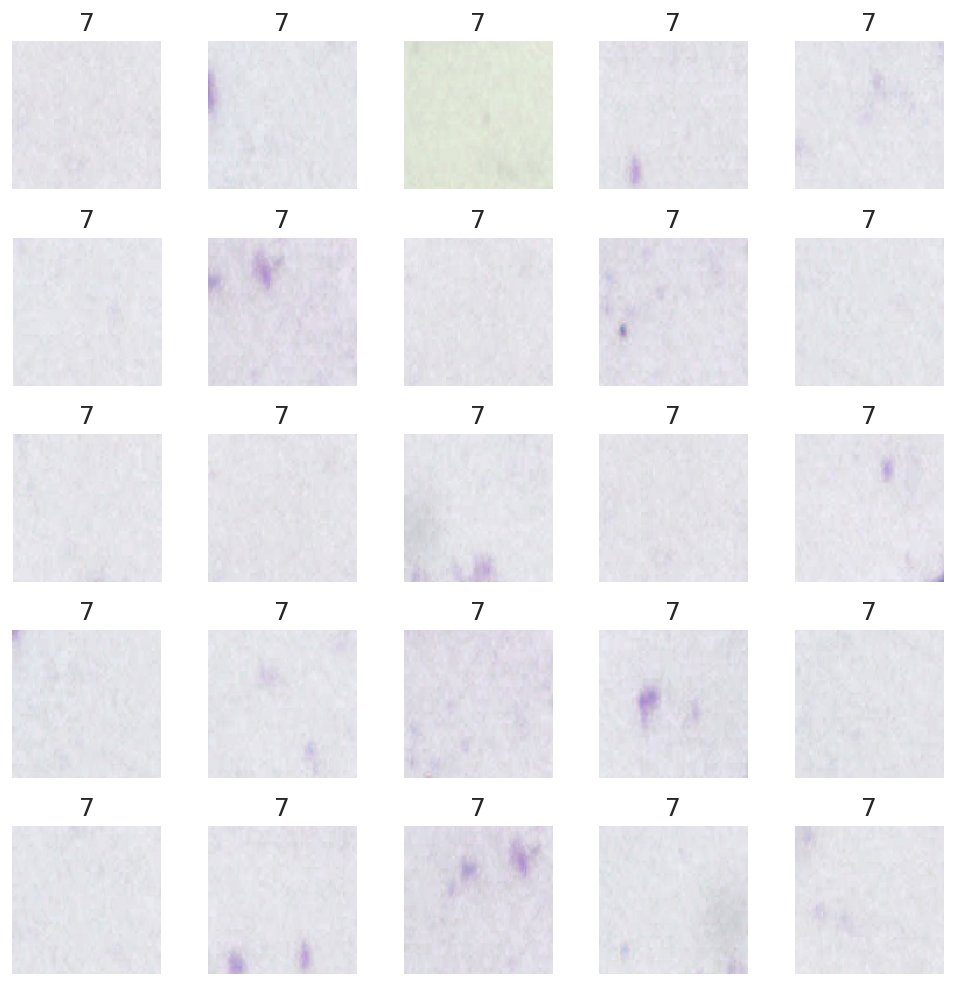

In [77]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5

for i in range(1, columns*rows+1 ):
    ax=fig.add_subplot(rows, columns, i)
    r1 = random.randint(1, 60) 
  
    ax.set_title(winclasses[r1])
    plt.imshow(winimgs[r1],interpolation='nearest')
    
    plt.axis('off')
plt.tight_layout()
plt.show()

Model of my neural network:

In [143]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (128,128,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2))) 
 
model.add(Conv2D(filters=32,kernel_size=2,activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16,kernel_size=2,activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",
				optimizer='ADAM',#RMSprop(lr=0.001) 'ADAM'
				metrics=["accuracy"])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 62, 62, 32)        2080      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 30, 30, 16)        2064      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 15, 16)       

Early stopping, maunal class weights used in experimentation. Ended up manually finding epoch number and ballanced dataset.

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [0]:
class_weight = {0: 0.5, 1: 10, 2: 4, 3: 10, 4: 10, 5: 10, 6: 10, 7: 0.5}#insert below: class_weight=class_weight,

Training the model, saving it, plotting accuracy.
The overall best classifier I got was trained about 200 epochs with both balanced, imbalanced, and background datasets seperately. This was achived through trial and error.

In [0]:
history = testmodel.fit(nptbboximages, nptclasses, batch_size=32, epochs=60, verbose=1,validation_data=(nptbboximages, nptclasses))

In [186]:
model_json = testmodel.to_json()
with open("model5.json", "w") as json_file :
	json_file.write(model_json)

testmodel.save_weights("model5.h5")
print("Saved model to disk")

testmodel.save('CNN5.model')

Saved model to disk


In [0]:
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

Testing single images.

3
[[1.2211590e-01 1.9670692e-03 3.7431422e-01 4.4791749e-01 3.9820713e-03
  6.0655326e-03 4.3583289e-02 5.4464024e-05]]


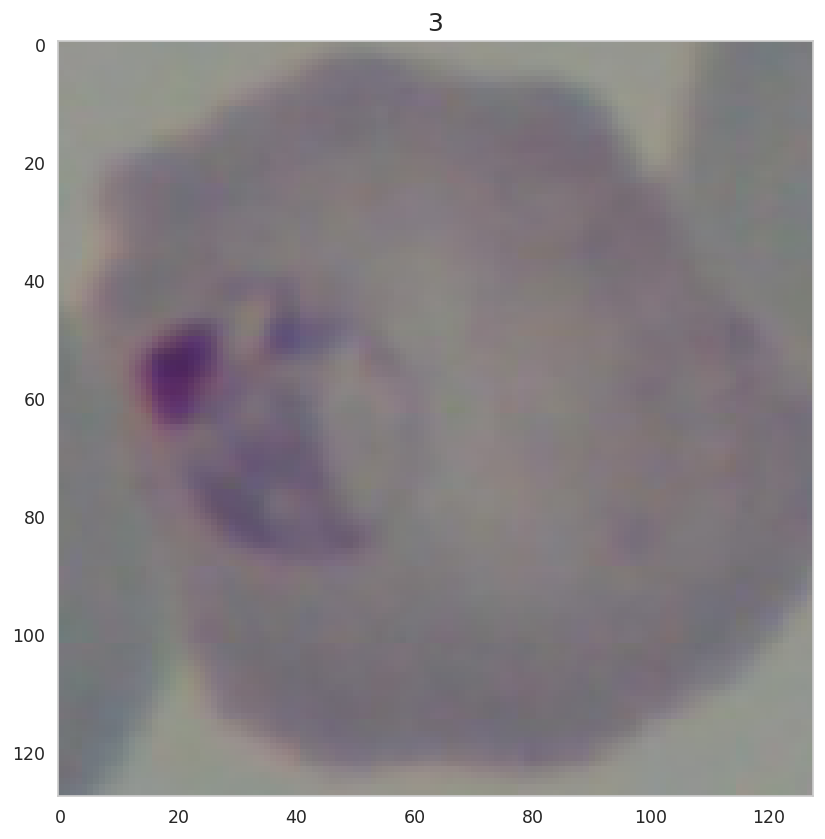

In [104]:
image_number=121 #63, 120,121,122
testimage=np.expand_dims(resize(nptbboximages[image_number], (128, 128)),axis=0) #class 2 
prediction = testmodel.predict(testimage)
print(prediction.argmax())
print(prediction)
plt.figure(figsize=(8, 8))
plt.title(tclasses[image_number])
plt.imshow(resize(nptbboximages[image_number], (128, 128)))
plt.show()

In [0]:
testmodel = tf.keras.models.load_model('/content/drive/My Drive/CNN5.model')

Testing a batch of images. 

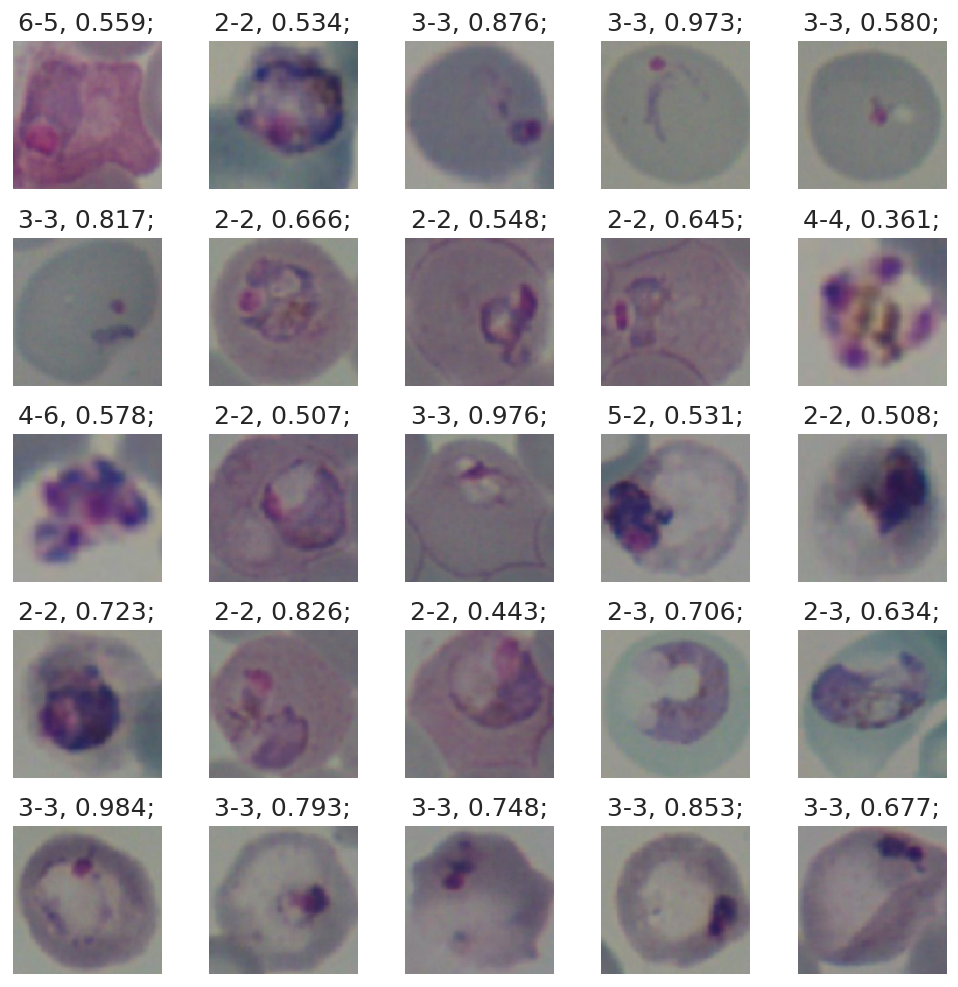

In [16]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
j=300

for i in range(1, columns*rows+1 ):
    ax =          fig.add_subplot(rows, columns, i)
    r1 =          random.randint(1, np.shape(nptbboximages)[0]) 
    j=j+1
    while(nptclasses[j]==0 and j<j+10):
       r1 =          random.randint(1, np.shape(nptbboximages)[0])
       j=j+1
    
    original =    nptclasses[j]
    testimage =   np.expand_dims((nptbboximages[j]),axis=0)
    predictiona = testmodel.predict(testimage)
    prediction =  predictiona.argmax()
    score =       predictiona[0][prediction]
    title =       "{}-{}, {:03.3f};".format(original,prediction,score) 
    ax.set_title(title)
    plt.imshow(np.squeeze(testimage),interpolation='nearest')
    
    plt.axis('off')
plt.tight_layout()
plt.show()

The Object detection testing is running through with a sliding window, classifying each image, then throwing out those which overlap and have a smaller score than what they overlap with it. It is quite slow and imprecise and misses cells all in all as well. If we change the window parameters we can get more through search results but it will be even slower and the precision does not increase inversely with this.

Drawing the image...


<Figure size 1250x1250 with 0 Axes>

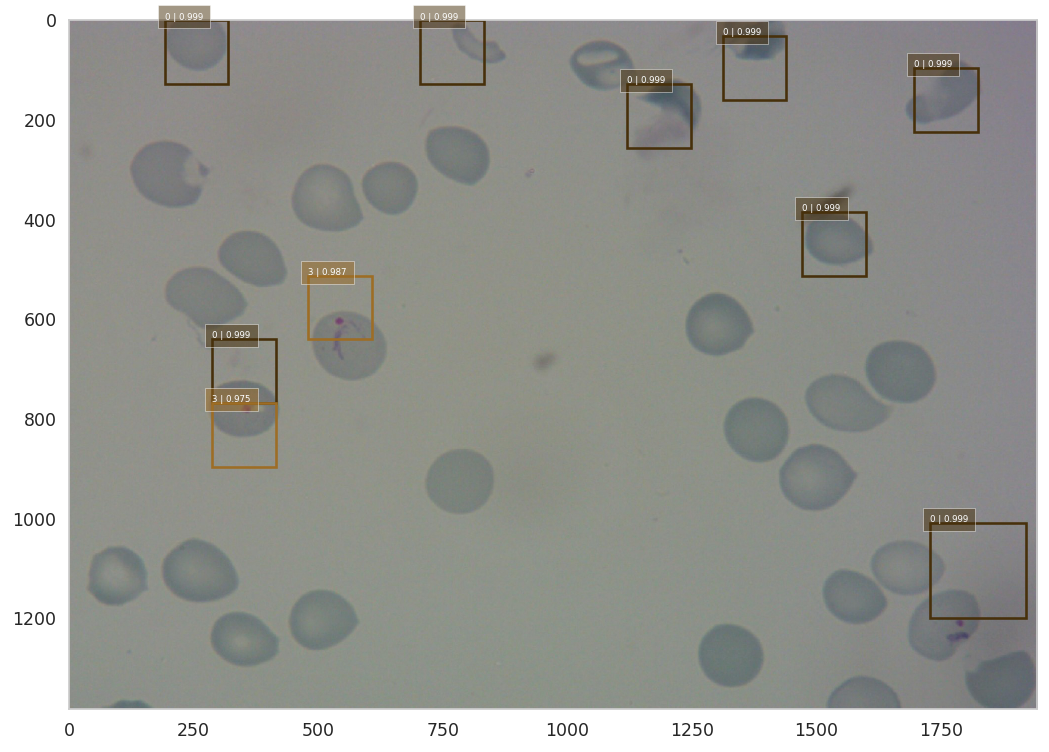

In [60]:
image_number=8
nms_threshold=0.5
Winsize= 128
stepsize= math.ceil(Winsize * 0.25)
(winW, winH) = (Winsize, Winsize)
figsize=(10,10)
fig = plt.figure(figsize=figsize)
winbboxes=[]
winclasses=[]
winscores=[]

c_img=get_image(image_number,istest=True)

print("Sliding window...")
for resized in pyramid(c_img, scale=1.5):   
  height = resized.shape[0]
  width = resized.shape[1]
  for (x, y, window) in sliding_window(resized, stepsize, windowSize=(winW, winH)):
    if window.shape[0] != winH or window.shape[1] != winW:
      continue
    
    img2 = resized[y:y+winH ,x:x+winW ,:]
    img2 = resize(img2, (128, 128))

    if x<1450 or y<1000 :
      prediction = testmodel.predict(np.expand_dims(img2,axis=0))
      if np.argmax(prediction)!=7:# and np.argmax(prediction)!=0:
        if np.squeeze(prediction)[np.argmax(prediction)]>0.9:
          winbboxes.append(np.array([  y/height, x/width, (y+winH)/height,  (x+winW)/width]))
          winclasses.append(np.argmax(prediction))
          winscores.append(np.squeeze(prediction)[np.argmax(prediction)]-0.001)


winbboxes=np.array(winbboxes)
winbboxes=np.reshape(winbboxes,(-1,4))
winscores=np.array(winscores)
winclasses=np.array(winclasses)

clear_output()        
print("Sorting...")
top_k=5000
idxes = np.argsort(-winscores)
winclasses = winclasses[idxes][:top_k]
winscores = winscores[idxes][:top_k]
winbboxes = winbboxes[idxes][:top_k]
clear_output()
print("Reducing number of bboxes...")
winclasses,winscores,winbboxes=bboxes_nms(winclasses,winscores,winbboxes,nms_threshold)
clear_output()
print("Drawing the image...")
plt_bboxes(c_img, winclasses, winscores, winbboxes)